# imports

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

from cycler import cycler
import numpy as np

import glob
import os

from functools import partial

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

<Figure size 432x288 with 0 Axes>

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [2]:
import copy

In [3]:
import pandas as pd

In [4]:
import phenom

In [5]:
os.sys.path.append("/Users/sebastian.khan/personal/git/stk/ml/waveforms/oct2022/uncertainty")

In [6]:
# custom module
import collocation as col

In [7]:
import sympy
# sympy.init_printing()
x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

In [8]:
# custom pn module for inspiral
import pn

In [9]:
# gpr fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern, DotProduct

# custom functions

In [10]:
def get_fdamp_from_q(q):
    """
    estimate ringdown damping frequency from mass-ratio `q`.
    """
    eta = phenom.eta_from_q(q)
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    fdamp = phenom.remnant.fdamp(eta, 0, 0, fin_spin)
    return fdamp

In [11]:
def get_fring_from_q(q):
    """
    estimate ringdown frequency from mass-ratio `q`.
    """
    eta = phenom.eta_from_q(q)
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    fring = phenom.remnant.fring(eta, 0, 0, fin_spin)
    return fring

In [12]:
catalogue_dir = "/Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022"

In [13]:
df = pd.read_csv(os.path.join(catalogue_dir, 'metadata.csv'))

In [14]:
times = np.load(os.path.join(catalogue_dir, 'times.npy'))

In [15]:
strains = np.load(os.path.join(catalogue_dir, 'strains.npy'))

In [16]:
strains.shape

(55, 8620)

In [17]:
df.shape

(55, 6)

In [18]:
df

name      q     fring     fdamp  duration  t_final
0    q18a0a0c025_96_fine  18.00  0.063334  0.014140    1020.0    465.8
1          q4a0_T_96_384   4.00  0.074330  0.014004    2202.1    229.5
2    q8a0a0_T_96_504n512   8.00  0.067697  0.014104     953.1    430.4
3     q8a0a0c05_T_80_420   8.00  0.067697  0.014104     941.9    259.8
4      q10c25e_T_112_448  10.00  0.066184  0.014119    1157.7    121.6
5          q4a0_T_80_320   4.00  0.074330  0.014004    2199.5    689.1
6        q18a0a0c025_144  18.00  0.063334  0.014140    1028.3     88.8
7   q8a0a0_T_112_588n768   8.00  0.067697  0.014104     957.9    207.8
8        q18a0a0c025_120  18.00  0.063334  0.014140    1027.5    174.7
9         q4a0_T_112_448   4.00  0.074330  0.014004    2202.5    151.8
10     SXS_BBH_0107_Res3   5.00  0.071862  0.014048    7440.1    449.9
11     SXS_BBH_0167_Res5   4.00  0.074330  0.014004    3115.7    404.1
12     SXS_BBH_0107_Res5   5.00  0.071862  0.014048    7465.5    451.5
13     SXS_BBH_0107_Res4   5.00  0.071862  0.014048    7457.2    449.8
14     SXS_BBH_0167_Res3   4.00  0.074330  0.014004    2874.0    403.8
15     SXS_BBH_0169_Res4   2.00  0.083149  0.013774    3458.2    406.7
16     SXS_BBH_0169_Res5   2.00  0.083149  0.013774    3468.3    406.6
17     SXS_BBH_0169_Res3   2.00  0.083149  0.013774    3088.2    406.7
18     SXS_BBH_0180_Res3   1.00  0.088087  0.013596    9359.5    236.6
19     SXS_BBH_0303_Res3  10.00  0.066184  0.014119    3397.6    498.9
20     SXS_BBH_0180_Res2   1.00  0.088087  0.013596    9354.6    236.8
21     SXS_BBH_0303_Res4  10.00  0.066184  0.014119    3433.2    499.1
22     SXS_BBH_0180_Res4   1.00  0.088087  0.013596    9270.5    236.4
23     SXS_BBH_0303_Res5  10.00  0.066184  0.014119    3461.4    499.7
24     RIT-BBH-0416-n140   7.00  0.068739  0.014092    2362.1    363.1
25     RIT-BBH-0084-n100   1.18  0.087761  0.013608    1602.1    396.2
26     RIT-BBH-0152-n120   5.00  0.071862  0.014048    4000.5    557.5
27    RIT-eBBH-1090-n100   1.00  0.088087  0.013596    1493.9    362.0
28    RIT-eBBH-1133-n100   4.00  0.074330  0.014004    2143.1    712.8
29    RIT-eBBH-1241-n100   1.33  0.087138  0.013633    1520.6    335.3
30     RIT-BBH-0942-n120  15.00  0.064066  0.014135    1162.8    330.2
31     RIT-BBH-0112-n100   1.00  0.088087  0.013596   16963.4    419.5
32     RIT-BBH-0139-n140   2.41  0.080777  0.013847    2736.9    423.5
33     RIT-BBH-0373-n140  15.00  0.064066  0.014135    2725.0    437.6
34     RIT-BBH-0792-n120  32.00  0.061687  0.014149    1558.3    191.2
35     RIT-BBH-0090-n100   6.00  0.070079  0.014075    1746.7    392.9
36     RIT-BBH-1020-n144   1.82  0.084262  0.013737    1368.2    249.8
37    RIT-eBBH-1200-n100   2.00  0.083149  0.013774    1637.8    318.1
38     RIT-BBH-0978-n144  10.00  0.066184  0.014119    1963.0    393.4
39     RIT-BBH-1025-n100  32.00  0.061687  0.014149    1474.0    240.2
40     RIT-BBH-0957-n084  15.00  0.064066  0.014135    1038.4    363.1
41                GT0379   2.20  0.081956  0.013812     936.3    616.9
42                GT0378   2.05  0.082845  0.013784     915.7    637.3
43                GT0757   2.25  0.081668  0.013820    1429.1    420.0
44                GT0380   2.35  0.081105  0.013837     957.9    595.3
45                GT0454   4.00  0.074330  0.014004    1855.1    495.1
46                GT0898   1.20  0.087693  0.013611    1793.9    286.8
47                GT0446   2.00  0.083149  0.013774    1378.6    470.3
48                GT0453   3.00  0.077907  0.013924    1599.7    549.9
49                GT0727   1.75  0.084699  0.013722    1330.0    418.7
50                GT0477   1.50  0.086221  0.013667    1286.6    361.9
51                GT0738   1.25  0.087500  0.013619    1252.6    395.9
52                GT0577   5.00  0.071862  0.014048    1281.6    574.2
53                GT0565   2.50  0.080296  0.013861    1484.2    465.0
54                GT0604   6.00  0.070079  0.014075    1496.1    460.8

In [19]:
names_to_drop = [
    'RIT-BBH-0957-n084', # this one is clearly too inaccurate
]

In [20]:
idxs_to_keep = df[~df['name'].isin(names_to_drop)].index

In [21]:
strains = strains[idxs_to_keep]

In [22]:
df = df.iloc[idxs_to_keep].copy().reset_index(drop=True)

In [23]:
strains.shape

(54, 8620)

In [24]:
df.shape

(54, 6)

In [25]:
amps=np.array([np.abs(strain) for strain in strains])
phases=np.array([np.unwrap(np.angle(strain)) for strain in strains])
freqs=np.array([IUS(times, phase).derivative()(times) for phase in phases])

In [26]:
amps = amps.T / phenom.eta_from_q(df['q'].values)
amps = amps.T

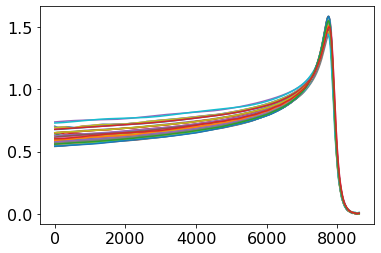

In [27]:
plt.plot(amps.T);

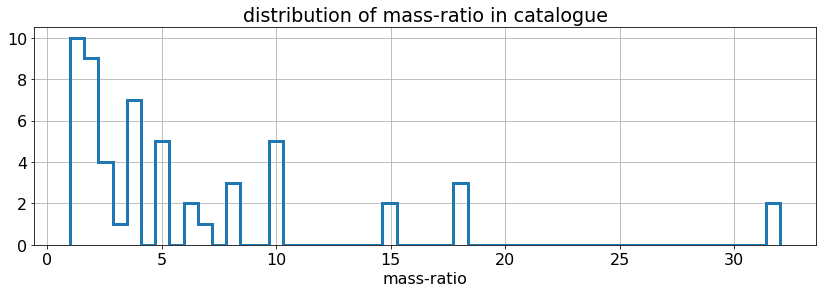

In [28]:
plt.figure(figsize=(14, 4))
plt.hist(df['q'], bins=50, histtype='step', lw=3)
plt.xlabel("mass-ratio");
plt.title("distribution of mass-ratio in catalogue")
plt.grid()

Text(0.5, 1.0, 'q18a0a0c025_96_fine')

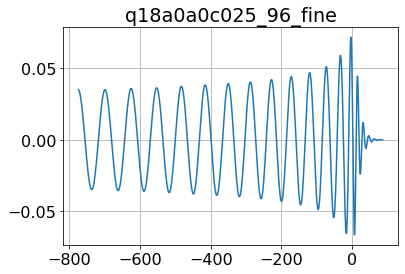

In [29]:
plt.plot(times, strains[0].real)
plt.grid()
plt.title(df.iloc[0]['name'])

# dev class

In [30]:
class Waveform(object):
    def __init__(self, strain, times, amp, phase, freq, q, meta_data=None):
        self.strain = strain
        self.times = times
        self.amp = amp
        self.phase = phase
        self.freq = freq
        self.q = q
        self.eta = phenom.eta_from_q(self.q)
        self.fin_spin = phenom.remnant.FinalSpin0815(self.eta, 0, 0)
        self.fring = phenom.remnant.fring(self.eta, 0, 0, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(self.eta, 0, 0, self.fin_spin)
        self.meta_data = meta_data

In [31]:
waveforms = [
    Waveform(
        strain=strains[i],
        times=times,
        amp=amps[i],
        phase=phases[i],
        freq=freqs[i],
        q=df['q'].values[i],
        meta_data=df.loc[[i]],
    )
    for i in range(len(strains))]

In [32]:
waveforms[0].q

18.0

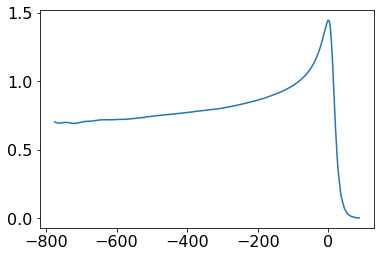

In [33]:
plt.plot(waveforms[0].times, waveforms[0].amp)

In [34]:
waveforms[0].__getattribute__("amp")

array([0.70274634, 0.70260065, 0.70245604, ..., 0.00188304, 0.0018431 ,
       0.00180313])

In [35]:
class WaveformFit(object):
    def __init__(self,
                 x,
                 y,
                 waveform,
                 # target,
                 collocation_points,
                 ansatz,
                 sub_dict={}, # empty dict by default
                 # t1=None,
                 # t2=None,
                 rhs_override=None,
                 pn=None,
                 **kwargs,
                ):
        """
        waveform: of type `Waveform`
        
        sub_dict: substitution dictionary for sympy ansatz
        
        pn: array of the prediction from PN theory.
            if this is given then we construct the residuals
            (y - pn) and fit this.
        """
        self.x = x
        self.y = y
        self.waveform = waveform
        # self.target = target
        self.collocation_points = collocation_points
        self.ansatz = ansatz.copy()
        self.sub_dict = sub_dict.copy()
        # self.x = self.waveform.__getattribute__('times')
        # self.y = self.waveform.__getattribute__(self.target)
        self.rhs_override = rhs_override
        self.pn = pn
        
        
        # if t1 == None:
        #     t1 = self.x.min()
        # if t2 == None:
        #     t2 = self.x.max()
        # self.t1 = t1
        # self.t2 = t2
        # self.mask = (self.x >= self.t1) & ((self.x <= self.t2))
        # self.x = self.x[self.mask]
        # self.y = self.y[self.mask]
        
        self.y_to_fit = self.y
        
        if self.pn is not None:
            # self.pn = self.pn[self.mask]
            self.pn_residuals = self.y - self.pn
            self.y_to_fit = self.pn_residuals

        # interpolate target so we can evaluate
        # it and it's derivative at any x value
        self.iy = IUS(self.x, self.y_to_fit)
        
        # evaluate interpolant at corresponding derivative order
        # and location
        self.rhs = {}
        for k in self.collocation_points.keys():
            v = map(self.iy.derivative(k), self.collocation_points[k])
            v = np.array(list(v))
            self.rhs[k] = v
            
        # override rhs
        if self.rhs_override is not None:
            for k in self.rhs_override.keys():
                for i, v in self.rhs_override[k]:
                    self.rhs[k][i] = v
        
            
        # change col.CollocationModel to take as input dictionaries for
        # `collocation_points` and `rhs`
        # with keys that are integer and represent the order of the derivative
        self.cm = col.CollocationModelNew(
            collocation_points=self.collocation_points,
            rhs=self.rhs,
            ansatz=self.ansatz,
            sub_dict=self.sub_dict,
        )

In [36]:
# note for the inspiral amplitude we have a 'base_ansatz'
# because we need to substitute some terms but because of
# dictionaries and passing by reference we want to keep
# the original un-substituted ansatz to be able to
# resuse the same dictionary for different binaries
waveform_fit_amp_inspiral=dict(
    name='amp_inspiral',
    target='amp',
    
    # base_ansatz = np.sum([x_sym**(-3./8), x_sym**(-4./8), x_sym**(-5./8), x_sym**(-6./8)]),
    # base_ansatz = np.sum([x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8), x_sym**(-12./8), x_sym**(-13./8)]),
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8)]),
    base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8)]),
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8), x_sym**(-12./8)]),
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8), x_sym**(-12./8), x_sym**(-13./8)]),
    collocation_points = {
        # 0:[-10000, -2000, -1000, -500, -300],
        # 0:[-6000, -2000, -1000, -500, -300],
        # 0:[-6000, -2000, -1000, -500, -100],
        # 0:[-2000, -1000, -500, -300],
        
        # 0:[-775, -500, -300],
        0:[-700, -500, -300],        
        # 0:[-700, -500, -300, -200],        
        
        
        # 0:[-10000, -2000, -1000, -500, -300, -100],
        # 0:[-60000, -2000, -1000, -500, -300],
        # 1:[-10000, -300],
        # 1:[-300],
    },
    t1=-2000,
    t2=-100,
    # rhs_override={0:[(0,1e-9)]}, # inspiral only! this is to enforce that the early inspiral is the recovered. because the lower frequency get's modified by choice of t0?
    # choose 1e-9 because it's a very small number, should be exactly zero though
)

In [37]:
# amplitude merger
waveform_fit_amp_merger=dict(
    name='amp_merger',
    target='amp',
    # base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(6)]),
    base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(5)]),
    # base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(4)]),
    collocation_points = {
        0:[-300, -100, -12, 0],
        # 1:[-300, 0],
        1:[0],
        # 1:[0],
        # 0:[-100, -12, 0],
        # 1:[-100, 0],
    },
    t1=-400,
    t2=50,
)

In [38]:
# amplitude ringdown
waveform_fit_amp_ringdown=dict(
    name='amp_ringdown',
    target='amp',
    # base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(7)]),
    base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(5)]),
    # base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(4)]),
    collocation_points = {
        0:[0, 5, 20, 30],
        # 1:[0, 20, 30],
        1:[0],
    },
    t1=-10,
    t2=40,
)

In [39]:
waveform_fit_freq_inspiral=dict(
    name='freq_inspiral',
    target='freq',
    # base_ansatz = np.sum([x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8), x_sym**(-12./8), x_sym**(-13./8)]),
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8), x_sym**(-12./8)]),
    
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8), x_sym**(-12./8), x_sym**(-13./8)]),
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8), x_sym**(-12./8)]),
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8)]),
    base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8)]),
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8)]),
    
    # base_ansatz = np.sum([x_sym**(-3./8), x_sym**(-4./8), x_sym**(-5./8), x_sym**(-6./8), x_sym**(-7./8), x_sym**(-8./8)]),
    # base_ansatz = np.sum([x_sym**(-4./8), x_sym**(-5./8), x_sym**(-6./8), x_sym**(-7./8), x_sym**(-8./8), x_sym**(-9./8)]),
    
    # base_ansatz = np.sum([x_sym**(2), x_sym**(1), x_sym**(0), x_sym**(-1), x_sym**(-2), x_sym**(-3)]),
    
    # base_ansatz = np.sum([x_sym**(-(8.+3)/8), x_sym**(-(9.+3)/8), x_sym**(-(10.+3)/8), x_sym**(-(11.+3)/8), x_sym**(-(12.+3)/8), x_sym**(-(13.+3)/8)]),
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8), x_sym**(-12./8), x_sym**(-13./8)]),
    # base_ansatz = np.sum([x_sym**(-8./8), x_sym**(-9./8), x_sym**(-10./8), x_sym**(-11./8), x_sym**(-12./8), x_sym**(-13./8), x_sym**(-14./8)]),
    collocation_points = {
        # 0:[-10000, -2000, -1000, -500, -300],
        # 0:[-10000, -2000, -1000, -500, -300],
        # 0:[-6000, -2000, -1500, -1000, -500, -300],
        # 0:[-2000, -1000, -500, -300],
        # 0:[-2000, -1500, -1000, -500, -300],
        
        # 0:[-2000, -1500, -1000, -700, -500, -300],
        # 0:[-2000, -1500, -1000, -500, -300],
        
        # 0:[-775, -500, -300],
        0:[-700, -500, -300],
        # 0:[-700, -300],
        # 0:[-700, -500, -300, -200],
        
        
        # 0:[-6000, -2000, -1500, -1000, -300],
        # 0:[-100000, -2000, -1500, -1000, -700, -500, -300],
        # 0:[-10000, -2000, -1000, -500, -300, -100],
        # 0:[-60000, -2000, -1000, -500, -300],
        # 1:[-300],
    },
    t1=-2000,
    t2=-100,
    # rhs_override={0:[(0,-1e-9)]}, # inspiral only! this is to enforce that the early inspiral is the recovered. because the lower frequency get's modified by choice of t0?
    # choose 1e-9 because it's a very small number, should be exactly zero though
    #NOTE: THE MINUS SIGN HERE BECAUSE THE SIGN OF THE (l,m)=(2,2) multipole is -ve in this frame
)

In [40]:
# freq merger
waveform_fit_freq_merger=dict(
    name='freq_merger',
    target='freq',
    # base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(9)]),
    # base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(8)]),
    # base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(7)]),
    # base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(6)]),
    # base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(5)]),
    base_ansatz = np.sum([sympy.asinh(a_sym * x_sym)**power for power in range(4)]),
    collocation_points = {
        # 0:[-300, -200, -100, -50, -30, -10, 0],
        # 0:[-300, -100, -50, -10, 0],
        0:[-300, -100, -12, 0],
        # 1:[-300, 0],
        # 1:[0],
        # 1:[-300],
        # 0:[-100, -50, -30, -10, 0],
        # 1:[-100, 0],
        # 0:[-100, -50, -10, 0],
        # 1:[-100, 0],
    },
    t1=-400,
    t2=10,
)

In [41]:
# freq ringdown
waveform_fit_freq_ringdown=dict(
    name='freq_ringdown',
    target='freq',
    # base_ansatz = np.sum([sympy.tanh(a_sym * x_sym)**power for power in range(5)]),
    base_ansatz = np.sum([sympy.tanh(a_sym * x_sym)**power for power in range(4)]),
    collocation_points = {
        0:[-10, 0, 10, 40],
        # 1:[0],
    },
    t1=-15,
    t2=50,
)

In [42]:
def prepare_fit_data(waveform, target, t1=None, t2=None):
    x = waveform.__getattribute__('times')
    y = waveform.__getattribute__(target)
    if t1 == None:
        t1 = x.min()
    if t2 == None:
        t2 = x.max()
        
    mask = (x >= t1) & (x <= t2)
    x = x[mask]
    y = y[mask]
    
    return x, y

In [110]:
# NEW
# we should explicitly pass in the x and y data

# waveform = waveforms[0]
# waveform = waveforms[6]
# waveform = waveforms[8]
waveform = waveforms[34]
# waveform = waveforms[39]
# waveform = waveforms[-1]
sub_dict = {"a_sym":waveform.fdamp*2*np.pi}

# Tc = 0
# Tc=200
# Tc=300
# Tc = 400
Tc = 1000

# waveform_fit_kwargs = waveform_fit_amp_merger.copy()
waveform_fit_kwargs = waveform_fit_amp_ringdown.copy()
# waveform_fit_kwargs = waveform_fit_freq_merger.copy()
# waveform_fit_kwargs = waveform_fit_freq_ringdown.copy()


# # when fitting inspiral
# waveform_fit_kwargs = waveform_fit_freq_inspiral.copy()
# waveform_fit_kwargs = waveform_fit_amp_inspiral.copy() # to avoid annoying dictionary pass by reference stuff
x, y = prepare_fit_data(waveform, waveform_fit_kwargs['target'], waveform_fit_kwargs['t1'], waveform_fit_kwargs['t2'])
# # somewhere I have assumed total mass is 1...

# # we get some warnings here because I am evaluating PN at very late times and ringdown times
# # would be better to not do that but this is how the code is set up right now.

# NOTE
# NOTE
# NOTE
# NOTE
# NOTE
# there should be different pn_sub_dict for amp and freq
# and the freq include the newtonain term \propto \theta**3/8
if 'inspiral' in waveform_fit_kwargs['name']:
    pn_kwargs=dict(t=x, tc=Tc, eta=waveform.eta, M=1)
    pn_sub_dict = {'x_sym': pn_kwargs['eta'] * (pn_kwargs['tc']-x_sym) / (5*pn_kwargs['M']) }
    # theta = pn_kwargs['eta'] * (pn_kwargs['tc']-x_sym) / (5*pn_kwargs['M'])
    # pn_sub_dict = {'x_sym': theta }
    waveform_fit_kwargs['ansatz'] = waveform_fit_kwargs['base_ansatz'].subs(pn_sub_dict)
    
if waveform_fit_kwargs['name'] == 'freq_inspiral':
    waveform_fit_kwargs.update({
        'pn':pn.TaylorT3_Omega_new(**pn_kwargs)
    })
elif waveform_fit_kwargs['name'] == 'amp_inspiral':
    waveform_fit_kwargs.update({
        'pn':np.abs(pn.Hhat22_T3(**pn_kwargs))
    })
else:
    waveform_fit_kwargs['ansatz'] = waveform_fit_kwargs['base_ansatz']



wff = WaveformFit(
    x=x,
    y=y,
    waveform=waveform,
    sub_dict=sub_dict,
    **waveform_fit_kwargs
)



In [111]:
# waveform_fit_kwargs['pn']

In [112]:
waveform_fit_kwargs['base_ansatz']

asinh(a_sym*x_sym)**4 + asinh(a_sym*x_sym)**3 + asinh(a_sym*x_sym)**2 + asinh(a_sym*x_sym) + 1

In [113]:
waveform_fit_kwargs['ansatz']

asinh(a_sym*x_sym)**4 + asinh(a_sym*x_sym)**3 + asinh(a_sym*x_sym)**2 + asinh(a_sym*x_sym) + 1

In [114]:
abs(waveform_fit_kwargs['ansatz'])

Abs(asinh(a_sym*x_sym)**4 + asinh(a_sym*x_sym)**3 + asinh(a_sym*x_sym)**2 + asinh(a_sym*x_sym) + 1)

In [115]:
wff.x;

In [116]:
wff.cm.rhs

{0: array([1.4414414 , 1.40211149, 0.69618997, 0.30545809]),
 1: array([6.72984284e-05])}

In [117]:
# waveform_fit_kwargs['pn']

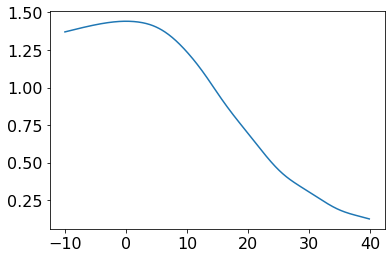

In [118]:
plt.plot(wff.x, wff.y_to_fit)

In [119]:
wff.cm.rhs

{0: array([1.4414414 , 1.40211149, 0.69618997, 0.30545809]),
 1: array([6.72984284e-05])}

In [120]:
wff.waveform.q

32.0

In [121]:
wff.cm.rhs

{0: array([1.4414414 , 1.40211149, 0.69618997, 0.30545809]),
 1: array([6.72984284e-05])}

In [122]:
wff.cm.collocation_points_1d

array([ 0,  5, 20, 30,  0])

In [123]:
wff.cm.rhs

{0: array([1.4414414 , 1.40211149, 0.69618997, 0.30545809]),
 1: array([6.72984284e-05])}

In [124]:
wff.cm.collocation_points

{0: [0, 5, 20, 30], 1: [0]}

In [125]:
wff.cm.coeffs

array([ 1.44144140e+00,  1.49071147e-02, -6.28600353e-01,  2.29241476e-01,
        7.57008690e-04])

In [126]:
wff.waveform.fring * 2 * np.pi

0.38758933297384224

In [127]:
wff.y_to_fit;

In [128]:
# wff.pn_residuals

In [129]:
wff.y;

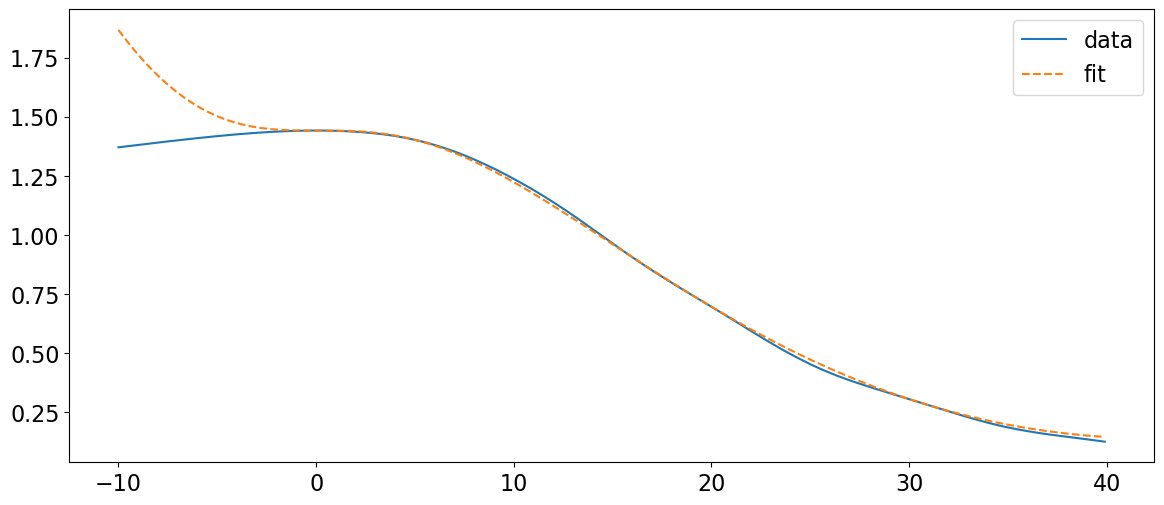

In [130]:
plt.figure(figsize=(14, 6), dpi=100)
plt.plot(wff.x, wff.y_to_fit, label='data')
plt.plot(wff.x, wff.cm.predict(wff.x), ls='--', label='fit')
# if wff.pn is not None:
#     plt.plot(wff.x, wff.pn, label='PN')

# for cp in wff.cm.collocation_points_1d:
#     plt.plot(cp, wff.cm.predict(cp, residual=IUS(wff.x, wff.pn)(cp)), 'o')

# plt.axhline(wff.waveform.fring * 2 * np.pi, c='k', ls='--')
# plt.xlim(-50,5)
# plt.yscale('log')
# plt.xscale('log')
plt.legend()

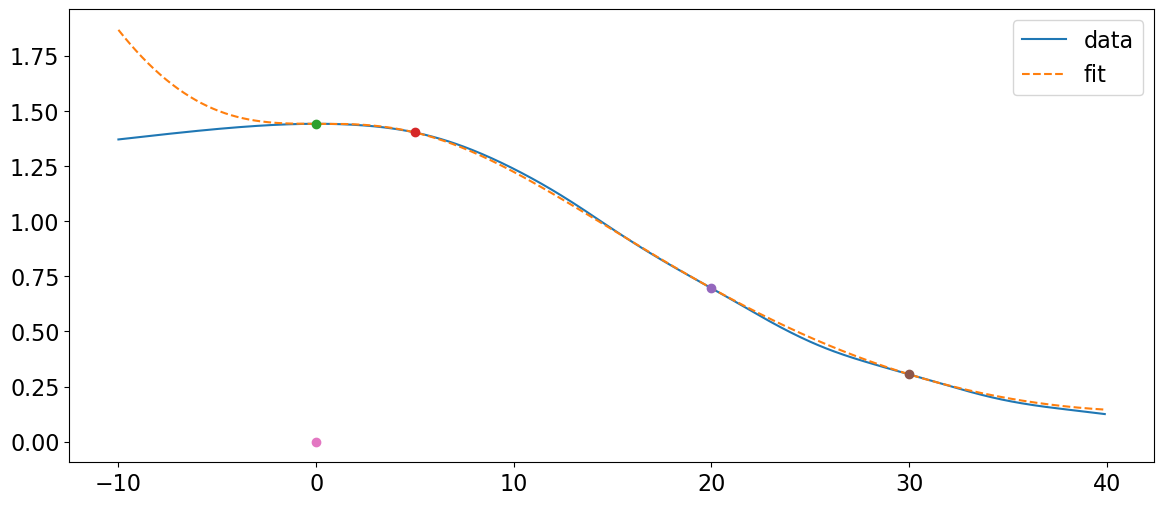

In [131]:
plt.figure(figsize=(14, 6), dpi=100)
plt.plot(wff.x, wff.y_to_fit, label='data')
plt.plot(wff.x, wff.cm.predict(wff.x), ls='--', label='fit')
    
for i, cp in enumerate(wff.cm.collocation_points_1d):
    plt.plot(cp, wff.cm.rhs_1d[i], 'o')
    
    
    

    
# plt.axhline(wff.waveform.fring * 2 * np.pi, c='k', ls='--')
# plt.xlim(-50,5)
# plt.yscale('log')
# plt.xscale('log')
plt.legend()

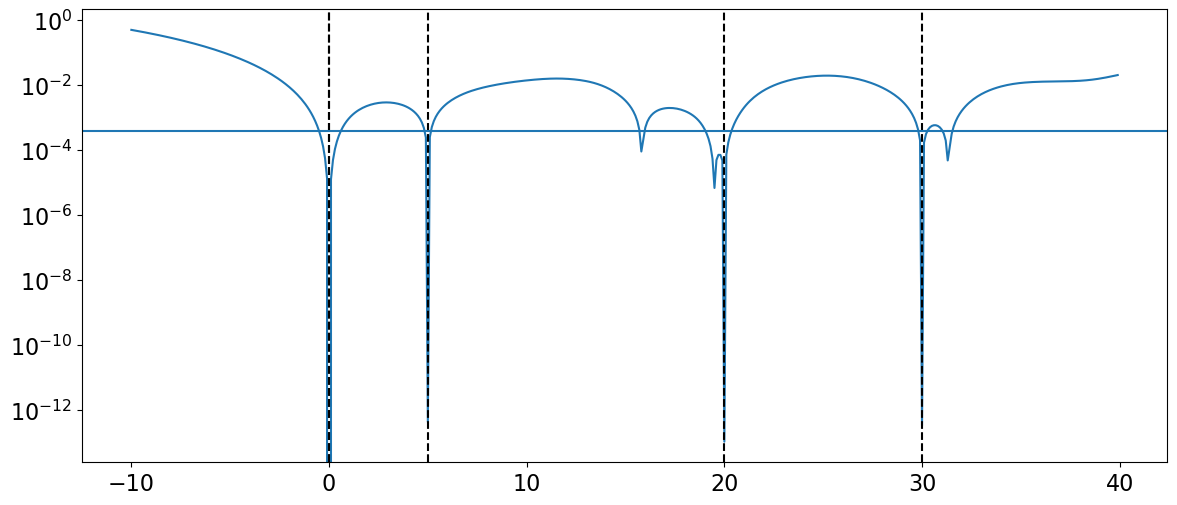

In [132]:
plt.figure(figsize=(14, 6), dpi=100)
plt.plot(wff.x, np.abs(wff.y_to_fit-wff.cm.predict(wff.x)))

for cp in wff.cm.collocation_points_1d:
    plt.axvline(cp, c='k', ls='--')

plt.yscale('log')
# plt.xlim(-50,5)
plt.axhline(4e-4)

# fit loops

In [133]:
# define train and test sets
# easiest to do with pandas

In [134]:
X = np.array([waveform.q for waveform in waveforms])
X = pd.DataFrame({'q':X})

In [135]:
# X_test = X.query('q >= 10 and q < 18')
# X_test = X.query('q >= 4 and q < 5 or q >= 18')
# X_test = X.query('q >= 4 and q < 5 or q >= 18 and q <= 19')
# X_test = X.query('q >= 4 and q <= 5')
# X_test = X.query('q >= 4 and q < 5')
# X_test = X.query('q >= 4 and q < 10')
# X_test = X.query('(q >= 4 and q < 5) or (q >= 32)')

# X_test = X.query('(q>1 and q<2) or (q>2 and q<4) or (q>=7 and q<10)')

# original
# X_test = X.query('(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10)')

# new: 10/01/23
X_test = X.query('(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10) or (q>=14 and q<16) or (q>=32 and q<33)')

In [136]:
X_train = X[~X.isin(X_test)].dropna()

In [137]:
X_train

q
0   18.0
4   10.0
6   18.0
8   18.0
10   5.0
12   5.0
13   5.0
15   2.0
16   2.0
17   2.0
18   1.0
19  10.0
20   1.0
21  10.0
22   1.0
23  10.0
26   5.0
27   1.0
31   1.0
35   6.0
37   2.0
38  10.0
46   2.0
51   5.0
53   6.0

In [138]:
X_test

q
1    4.00
2    8.00
3    8.00
5    4.00
7    8.00
9    4.00
11   4.00
14   4.00
24   7.00
25   1.18
28   4.00
29   1.33
30  15.00
32   2.41
33  15.00
34  32.00
36   1.82
39  32.00
40   2.20
41   2.05
42   2.25
43   2.35
44   4.00
45   1.20
47   3.00
48   1.75
49   1.50
50   1.25
52   2.50

In [139]:
waveforms_train = [waveforms[i] for i in X_train.index]
waveforms_test = [waveforms[i] for i in X_test.index]

In [140]:
[wf.q for wf in waveforms_train]

[18.0,
 10.0,
 18.0,
 18.0,
 5.0,
 5.0,
 5.0,
 2.0,
 2.0,
 2.0,
 1.0,
 10.0,
 1.0,
 10.0,
 1.0,
 10.0,
 5.0,
 1.0,
 1.0,
 6.0,
 2.0,
 10.0,
 2.0,
 5.0,
 6.0]

In [141]:
[wf.q for wf in waveforms_test]

[4.0,
 8.0,
 8.0,
 4.0,
 8.0,
 4.0,
 4.0,
 4.0,
 7.0,
 1.18,
 4.0,
 1.33,
 15.0,
 2.41,
 15.0,
 32.0,
 1.82,
 32.0,
 2.2,
 2.05,
 2.25,
 2.35,
 4.0,
 1.2,
 3.0,
 1.75,
 1.5,
 1.25,
 2.5]

In [164]:

# waveform_fit_kwargs = waveform_fit_amp_inspiral.copy()
# waveform_fit_kwargs = waveform_fit_freq_inspiral.copy()

# waveform_fit_kwargs = waveform_fit_amp_merger.copy()
waveform_fit_kwargs = waveform_fit_amp_ringdown.copy()
# waveform_fit_kwargs = waveform_fit_freq_merger.copy()
# waveform_fit_kwargs = waveform_fit_freq_ringdown.copy()

In [165]:
waveform_fit_kwargs

{'name': 'amp_ringdown',
 'target': 'amp',
 'base_ansatz': asinh(a_sym*x_sym)**4 + asinh(a_sym*x_sym)**3 + asinh(a_sym*x_sym)**2 + asinh(a_sym*x_sym) + 1,
 'collocation_points': {0: [0, 5, 20, 30], 1: [0]},
 't1': -10,
 't2': 40}

In [166]:
wffs_train=[]
for waveform in waveforms_train:
    x, y = prepare_fit_data(waveform, waveform_fit_kwargs['target'], waveform_fit_kwargs['t1'], waveform_fit_kwargs['t2'])
    
    # if fitting inspiral amplitude
    if 'inspiral' in waveform_fit_kwargs['name']:
        pn_kwargs=dict(t=x, tc=Tc, eta=waveform.eta, M=1)
        pn_sub_dict = {'x_sym': pn_kwargs['eta'] * (pn_kwargs['tc']-x_sym) / (5*pn_kwargs['M']) }
        waveform_fit_kwargs['ansatz'] = waveform_fit_kwargs['base_ansatz'].subs(pn_sub_dict)
        sub_dict = {}
    if waveform_fit_kwargs['name'] == 'amp_inspiral':
        # pass
        waveform_fit_kwargs.update({
            'pn':np.abs(pn.Hhat22_T3(**pn_kwargs))
        })
    elif waveform_fit_kwargs['name'] == 'freq_inspiral':
        # pass
        waveform_fit_kwargs.update({
            'pn':pn.TaylorT3_Omega_new(**pn_kwargs)
        })
    else:
        waveform_fit_kwargs['ansatz'] = waveform_fit_kwargs['base_ansatz']
        sub_dict = {"a_sym":waveform.fdamp*2*np.pi}

    
    wff = WaveformFit(
        x=x,
        y=y,
        waveform=waveform,
        sub_dict=sub_dict,
        **waveform_fit_kwargs
    )
    wffs_train.append(wff)

In [167]:
wffs_test=[]
for waveform in waveforms_test:
    x, y = prepare_fit_data(waveform, waveform_fit_kwargs['target'], waveform_fit_kwargs['t1'], waveform_fit_kwargs['t2'])
    
    # if fitting inspiral amplitude
    if 'inspiral' in waveform_fit_kwargs['name']:
        pn_kwargs=dict(t=x, tc=Tc, eta=waveform.eta, M=1)
        pn_sub_dict = {'x_sym': pn_kwargs['eta'] * (pn_kwargs['tc']-x_sym) / (5*pn_kwargs['M']) }
        waveform_fit_kwargs['ansatz'] = waveform_fit_kwargs['base_ansatz'].subs(pn_sub_dict)
        sub_dict = {}
    if waveform_fit_kwargs['name'] == 'amp_inspiral':
        # pass
        waveform_fit_kwargs.update({
            'pn':np.abs(pn.Hhat22_T3(**pn_kwargs))
        })
    elif waveform_fit_kwargs['name'] == 'freq_inspiral':
        # pass
        waveform_fit_kwargs.update({
            'pn':pn.TaylorT3_Omega_new(**pn_kwargs)
        })
    else:
        waveform_fit_kwargs['ansatz'] = waveform_fit_kwargs['base_ansatz']
        sub_dict = {"a_sym":waveform.fdamp*2*np.pi}

    
    wff = WaveformFit(
        x=x,
        y=y,
        waveform=waveform,
        sub_dict=sub_dict,
        **waveform_fit_kwargs
    )
    wffs_test.append(wff)

Text(0.5, 0, 'q')

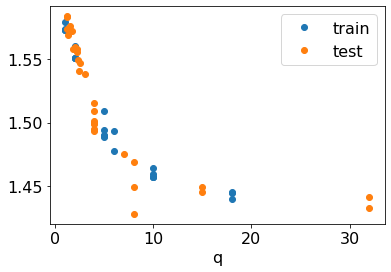

In [168]:
plt.plot([wff.waveform.q for wff in wffs_train], [wff.cm.rhs[0][0] for wff in wffs_train], 'o', label='train')
plt.plot([wff.waveform.q for wff in wffs_test], [wff.cm.rhs[0][0] for wff in wffs_test], 'o', label='test')
plt.legend()
plt.xlabel("q")

# parameter space fits

In [169]:
class ParameterSpaceFits(object):
    """
    collect together the results from the individual fits and then fit them using GPR
    """
    def __init__(self, wffs):
        
        self.wffs = wffs
        
        # the independent variable
        # if it were aligned spin it would be a (N, 3) matrix
        # where N is the number of waveforms and the columns
        # would be ['q', 'chi1', 'chi2']
        self.xs = np.array([wff.waveform.q for wff in self.wffs])
        
        # useful for setting length of loops
        self.num_collocation_points = {}
        for d in self.wffs[0].collocation_points.keys():
            self.num_collocation_points[d] = len(self.wffs[0].collocation_points[d])
            
        # ys: stores the targets for parameter space fits.
        # it has the same structure as rhs.
        # i.e. the keys are integers and correspond to the
        # derivative order
        # for each key the values are a list of length equal
        # to the number of collocation points
        ys = {}
        # signs: records the sign i.e. -ve or +ve for each data point
        # we need this is we use the log(abs()) transformation to be able
        # to recover the original sign of the data.
        signs = {}
        # loop over derivatives
        for d in self.wffs[0].cm.rhs.keys():
            ys[d] = []
            signs[d] = []
            # loop over collocation points
            for c in range(self.num_collocation_points[d]):
                t = np.array([wff.cm.rhs[d][c] for wff in self.wffs])
                ys[d].append(t)
                s = [np.sign(t_) for t_ in t][0] # assumption: take sign from first waveform
                signs[d].append(s)
        self.ys = ys
        self.signs = signs
        
    def compute_alphas(self):
        """
        sets the self.alphas attribute
        use this when you have multiple observations i.e. multiple mass-ratio x simulations
        for each collocation point we compute the standard deviation over observations
        and use this as a proxy for the uncertainty in that data point.
        for data points where we only have one observation we assume that their uncertainty
        is given by the median value of the distribution of standard deviations
        """
        alphas = {}
        for d in self.wffs[0].cm.rhs.keys():
            alphas[d] = []
            for c in range(self.num_collocation_points[d]):
                # create a dataframe so we can group by easily
                df=pd.DataFrame({'x':self.xs, 'y':self.ys[d][c]})
                # group by mass-ratio and compute standard deviation
                df2=df.groupby(by='x').std()
                df2=df2.rename(columns={'y':'alpha'})
                # remove nans (these are the cases were only one simulation exists)
                # and compute the median value of the distribution of stds
                median_std = np.median(df2['alpha'].values[~np.isnan(df2['alpha'].values)])

                # impute nans with median value
                # join back onto original dataframe so that we have a value of alpha
                # for every data point
                df3=pd.merge(df, df2.fillna(median_std), left_on='x', right_index=True).sort_index()
                alphas[d].append(df3['alpha'].values)
        self.alphas = alphas
        
    def fit(self, GaussianProcessRegressor_kwargs, log_abs_transform=True, use_estimate_alpha=True):
        """
        use_estimate_alpha: if this is true then will use an estimate for alpha based on the data
        """
        if use_estimate_alpha == True:
            assert hasattr(self, 'alphas'), "attribute alphas not set"
        GaussianProcessRegressor_kwargs = GaussianProcessRegressor_kwargs.copy()
        self.log_abs_transform = log_abs_transform
        # loop of self.ys and build a fit
        yhats = {}
        gprs = {}
        # loop over derivatives
        for d in self.ys.keys():
            # loop over collocation points
            yhats[d] = []
            gprs[d] = []
            for c in range(self.num_collocation_points[d]):
                x = self.xs
                y = self.ys[d][c]
                if self.log_abs_transform:
                    y = np.log(np.abs(y))
                if use_estimate_alpha == True:
                    GaussianProcessRegressor_kwargs.update({'alpha':self.alphas[d][c]})
                gpr = GaussianProcessRegressor(**GaussianProcessRegressor_kwargs).fit(x[:,np.newaxis], y)
                gprs[d].append(gpr)
                
        self.gprs = gprs
                
    def predict_sample(self, x, num_samples, random_state=1):
        mus = {}
        for d in self.gprs.keys():
            mus[d] = []
            for c in range(self.num_collocation_points[d]):
                mu = self.gprs[d][c].sample_y(x, num_samples, random_state=random_state)
                if self.log_abs_transform:
                    s = np.array(self.signs[d][c])
                    mu = s * np.exp(mu)
                mus[d].append(mu.T)
        return mus
    
    def predict_mean(self, x):
        mus = {}
        for d in self.gprs.keys():
            mus[d] = []
            for c in range(self.num_collocation_points[d]):
                mu = self.gprs[d][c].predict(x)
                if self.log_abs_transform:
                    s = np.array(self.signs[d][c])
                    mu = s * np.exp(mu)
                # we add a new axis in first position so that we get a shape (1, n) so that it is consistent with 
                # how we treat many samples which a shape (n_samples, n)
                mus[d].append(mu[np.newaxis, :])
                # mus[d].append([mu])
                # mus[d].append(mu)
        return mus

In [170]:
psf_train = ParameterSpaceFits(wffs_train)

In [171]:
psf_train.compute_alphas()

In [172]:
psf_train.alphas

{0: [array([0.00333919, 0.00307326, 0.00333919, 0.00333919, 0.00864405,
         0.00864405, 0.00864405, 0.00419108, 0.00419108, 0.00419108,
         0.00288963, 0.00307326, 0.00288963, 0.00307326, 0.00288963,
         0.00307326, 0.00864405, 0.00288963, 0.00288963, 0.01082832,
         0.00419108, 0.00307326, 0.00419108, 0.00864405, 0.01082832]),
  array([0.00447093, 0.00354139, 0.00447093, 0.00447093, 0.0165568 ,
         0.0165568 , 0.0165568 , 0.02446065, 0.02446065, 0.02446065,
         0.00534756, 0.00354139, 0.00534756, 0.00354139, 0.00534756,
         0.00354139, 0.0165568 , 0.00534756, 0.00534756, 0.03691158,
         0.02446065, 0.00354139, 0.02446065, 0.0165568 , 0.03691158]),
  array([0.00773386, 0.01165052, 0.00773386, 0.00773386, 0.02292957,
         0.02292957, 0.02292957, 0.05068058, 0.05068058, 0.05068058,
         0.011411  , 0.01165052, 0.011411  , 0.01165052, 0.011411  ,
         0.01165052, 0.02292957, 0.011411  , 0.011411  , 0.07755987,
         0.05068058, 0.0116

In [173]:
psf_train.signs

{0: [1.0, 1.0, 1.0, 1.0], 1: [1.0]}

In [174]:
psf_test = ParameterSpaceFits(wffs_test)

In [175]:
psf_train.xs

array([18., 10., 18., 18.,  5.,  5.,  5.,  2.,  2.,  2.,  1., 10.,  1.,
       10.,  1., 10.,  5.,  1.,  1.,  6.,  2., 10.,  2.,  5.,  6.])

In [176]:
# # we can use alphas to change the level of uncertainty on different points
# # in the training set
# alphas = np.ones_like(psf_train.xs)
# # alphas[psf_train.xs < 6] = 1e-3
# # alphas[psf_train.xs >= 6] = 1e-2
# alphas[psf_train.xs < 18] = 1e-3
# alphas[psf_train.xs >= 18] = 1e-2
# # alphas[psf_train.xs < 18] = 1e-4
# # alphas[psf_train.xs >= 18] = 1e-1
# alphas

In [177]:
GaussianProcessRegressor_kwargs=dict(
    # kernel=Matern(nu=2.5) * ConstantKernel(),
    # kernel=Matern(nu=2.5, length_scale_bounds=(1e-16, 100000.0)) * ConstantKernel(constant_value_bounds=(1e-16, 100000.0)) + DotProduct(sigma_0_bounds=(1e-16, 100000.0)) * ConstantKernel(constant_value_bounds=(1e-16, 100000.0)),
    # kernel=DotProduct() * ConstantKernel() + WhiteKernel(),
    # kernel=Matern(nu=2.5) * ConstantKernel(),
    kernel=Matern(nu=2.5) * ConstantKernel() + DotProduct() * ConstantKernel(),
    # kernel=Matern(nu=2.5) * ConstantKernel() + DotProduct() *DotProduct() * ConstantKernel(),
    # kernel=RBF() * ConstantKernel() + DotProduct() * ConstantKernel(),
    # kernel=Matern(nu=2.5) * ConstantKernel() + DotProduct() * ConstantKernel() + DotProduct() * ConstantKernel(),
    # kernel=Matern(nu=2.5) * ConstantKernel() + DotProduct() * ConstantKernel() + DotProduct() * DotProduct() * ConstantKernel(),
    # kernel=Matern(nu=2.5) * ConstantKernel(),
    # kernel=DotProduct() * ConstantKernel(),
    # kernel=RationalQuadratic() * ConstantKernel() + DotProduct() * ConstantKernel(),
    # alpha=1e-1,
    # alpha=1e-2,
    # alpha=1e-3, ## this is normally used i think
    # alpha=alphas,
    # alpha=1e-4,
    # alpha=1e-5,
    random_state=0,
    normalize_y=True,
    n_restarts_optimizer=100,
    # optimizer=None
)

In [193]:
psf_train.fit(GaussianProcessRegressor_kwargs, log_abs_transform=True, use_estimate_alpha=True)

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

In [194]:
q_fine = np.linspace(1, 40, 100)[:,np.newaxis]

In [195]:
psf_train.predict_sample([[1]], 1)

{0: [array([[1.57580974]]),
  array([[1.50728287]]),
  array([[0.67562303]]),
  array([[0.28247839]])],
 1: [array([[0.00028327]])]}

In [196]:
mus = psf_train.predict_sample(q_fine, 50)
mu = psf_train.predict_mean(q_fine)

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:479: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


In [197]:
mus[0][0].shape

(50, 100)

In [198]:
mu[0][0].shape

(1, 100)

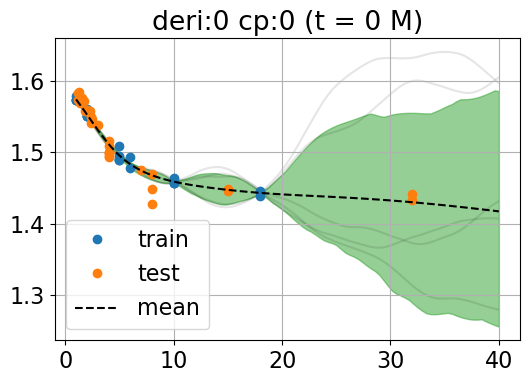

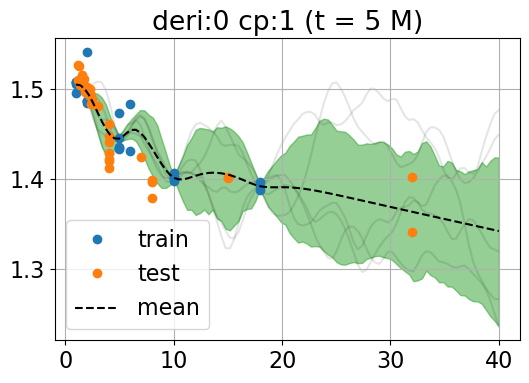

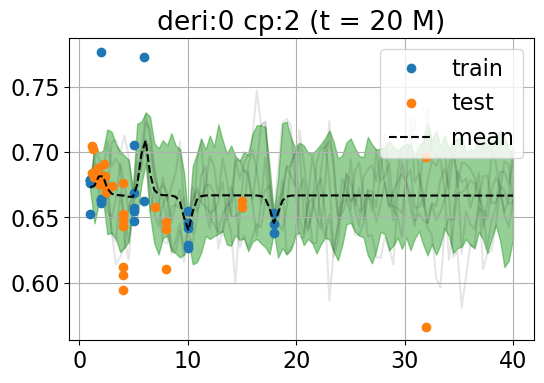

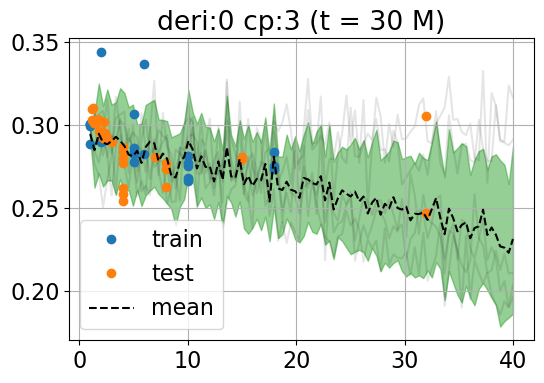

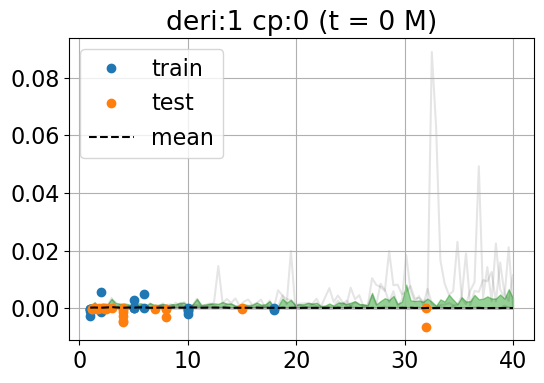

In [184]:
# d=0
# c=0

for d in psf_train.wffs[0].collocation_points.keys():
    for c, cp in enumerate(psf_train.wffs[0].collocation_points[d]):

        # sample_mu = mus[d][c].mean(0)
        # because we have the log(abs()) transformation I think
        # the correct way to get the error estimate is to get the
        # percentile and not the std.
        # sample_std = mus[d][c].std(0)
        
        sample_5 = np.percentile(mus[d][c], 5, 0)
        sample_95 = np.percentile(mus[d][c], 95, 0)

        plt.figure(dpi=100)
        plt.plot(psf_train.xs, psf_train.ys[d][c], 'o', label='train')
        plt.plot(psf_test.xs, psf_test.ys[d][c], 'o', label='test')
        plt.plot(q_fine, mu[d][c][0], c='k', ls='--', label='mean')

        # plt.plot(q_fine, sample_mu,  c='C2', label='sample')
        # plt.fill_between(q_fine[:,0], y1=sample_mu-sample_std, y2=sample_mu+sample_std, alpha=0.5, color='C2')
        plt.fill_between(q_fine[:,0], y1=sample_5, y2=sample_95, alpha=0.5, color='C2')

        for mu_sample in mus[d][c][:5]:
            plt.plot(q_fine, mu_sample, c='k', alpha=0.1, zorder=1)

        plt.legend()

        title = f"deri:{d} cp:{c} (t = {cp} M)"
        plt.title(title)
        plt.grid()
        # plt.xlim(0.5, 8)
        # plt.ylim(0.1, 0.15)
        # plt.xlim(0.5, 5)
        # plt.ylim(0.1, 0.13)
        # plt.xlim(8, 34)
        # plt.ylim(0.12, 0.16)
        # plt.xlim(14, 20)
        # plt.ylim(0.13, 0.14)
        # plt.ylim(0.14, 0.15)
        # plt.ylim(0.15, 0.16)
        # plt.yscale('log')
        # plt.xscale('log')

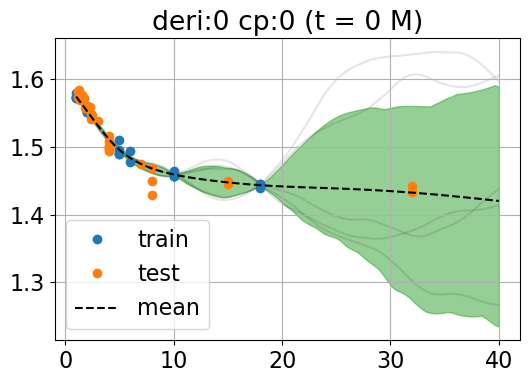

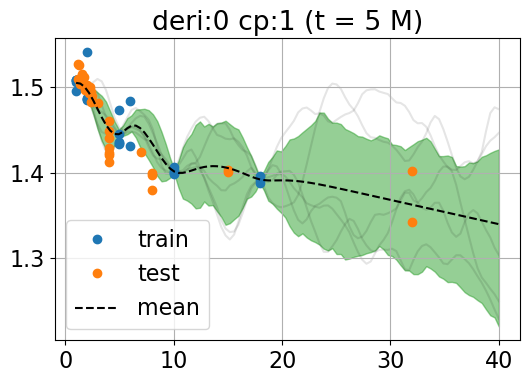

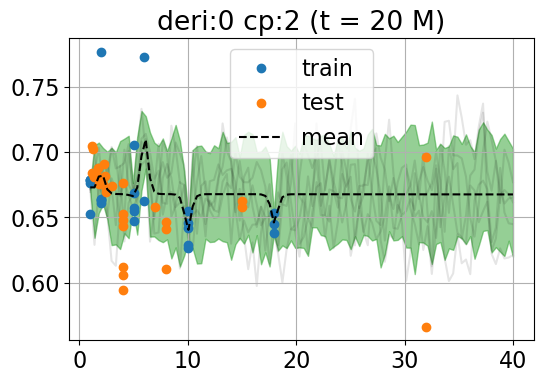

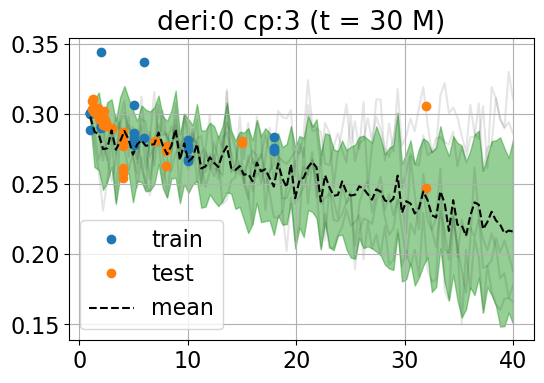

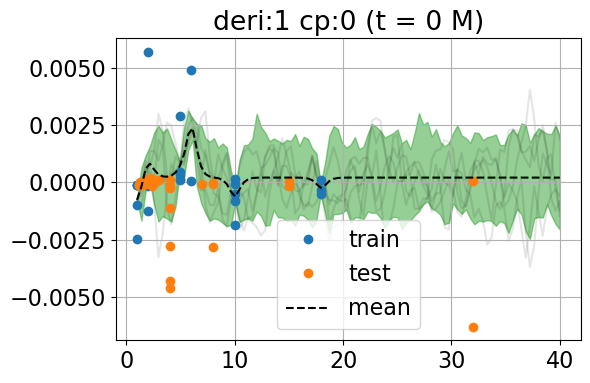

In [192]:
# d=0
# c=0

for d in psf_train.wffs[0].collocation_points.keys():
    for c, cp in enumerate(psf_train.wffs[0].collocation_points[d]):

        # sample_mu = mus[d][c].mean(0)
        # because we have the log(abs()) transformation I think
        # the correct way to get the error estimate is to get the
        # percentile and not the std.
        # sample_std = mus[d][c].std(0)
        
        sample_5 = np.percentile(mus[d][c], 5, 0)
        sample_95 = np.percentile(mus[d][c], 95, 0)

        plt.figure(dpi=100)
        plt.plot(psf_train.xs, psf_train.ys[d][c], 'o', label='train')
        plt.plot(psf_test.xs, psf_test.ys[d][c], 'o', label='test')
        plt.plot(q_fine, mu[d][c][0], c='k', ls='--', label='mean')

        # plt.plot(q_fine, sample_mu,  c='C2', label='sample')
        # plt.fill_between(q_fine[:,0], y1=sample_mu-sample_std, y2=sample_mu+sample_std, alpha=0.5, color='C2')
        plt.fill_between(q_fine[:,0], y1=sample_5, y2=sample_95, alpha=0.5, color='C2')

        for mu_sample in mus[d][c][:5]:
            plt.plot(q_fine, mu_sample, c='k', alpha=0.1, zorder=1)

        plt.legend()

        title = f"deri:{d} cp:{c} (t = {cp} M)"
        plt.title(title)
        plt.grid()
        # plt.xlim(0.5, 8)
        # plt.ylim(0.1, 0.15)
        # plt.xlim(0.5, 5)
        # plt.ylim(0.1, 0.13)
        # plt.xlim(8, 34)
        # plt.ylim(0.12, 0.16)
        # plt.xlim(14, 20)
        # plt.ylim(0.13, 0.14)
        # plt.ylim(0.14, 0.15)
        # plt.ylim(0.15, 0.16)
        # plt.yscale('log')
        # plt.xscale('log')